In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,r2_score
import xgboost as xgb
from matplotlib import pyplot as plt

In [2]:
data_dir = "F:/TARGET frontier/TXT33/"
data_name = "train"
tail = "fe2"
train_data = pd.DataFrame()
for i in range(2015,2019):
    res = pd.read_csv(data_dir+data_name+str(i)+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})
    train_data = pd.concat([train_data,res])

In [3]:
pd.set_option('display.max_columns', 100)
train_data.head()

,場所,芝・ダ,距離,クラス名,馬場状態,騎手コード,枠番,性別,年齢,キャリア,斤量,間隔,休み明け〜戦目,種牡馬,父タイプ名,調教師コード,前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走騎手コード,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走PCI3,前走RPCI,前PCI,前好走,前走平均1Fタイム,前走着差タイム,前走単勝オッズ,着差,レースID(旧),複勝オッズ下限,複勝オッズ上限,複勝配当,単勝オッズ
0,2,2,1200,2,3,5212,6,2,3,13,56.0,6.0,5.0,364,8,1105,13,2,1400.0,2,2,660.0,2.0,3,54.0,37.2,33.9,59.53,58.2,59.7,0,11.93,0.2,14.6,0.0,0615581112,1.9,2.7,190.0,5.4
1,2,2,1200,2,3,5339,6,1,3,10,54.0,3.0,3.0,281,8,1002,1,2,1200.0,4,3,5339.0,7.0,3,54.0,34.5,34.6,48.80,46.9,49.7,0,11.52,0.0,2.2,0.0,0615581111,1.3,1.6,130.0,2.8
2,2,2,1200,2,3,5203,3,2,3,9,56.0,5.0,2.0,387,5,1089,3,2,1200.0,2,3,1018.0,8.0,2,56.0,34.5,34.4,50.13,48.0,50.3,0,11.48,0.4,28.6,0.2,0615581106,1.8,2.5,180.0,6.2
3,2,2,1200,2,3,1150,4,1,5,17,55.0,2.0,4.0,56,1,1134,2,2,1200.0,2,2,1150.0,6.0,2,53.0,34.1,34.4,48.17,46.3,49.1,0,11.42,0.0,19.1,0.3,0615581108,1.7,2.5,0.0,6.6
4,2,2,1200,2,3,1004,8,1,3,15,54.0,2.0,4.0,193,4,1030,2,2,1200.0,2,2,1134.0,2.0,5,53.0,33.6,36.4,48.17,46.3,42.3,1,11.67,1.5,8.6,0.3,0615581116,6.3,9.7,0.0,33.9


In [4]:
#test_data
test_data = pd.read_csv(data_dir+"predict2019"+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})
test_x = test_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当"],axis=1)
test_y = test_data["着差"]

In [5]:
train_x = train_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当"],axis=1)
train_y = train_data["着差"]

In [6]:
#ベースライン
params = {
    'booster':'gbtree',
    'objective':'reg:squarederror',
    'eta':0.01,
    'gamma':0.0,
    'alpha':0.0,
    'lambda':1.0,
    'min_child_weight':1,
    'max_depth':6,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'random_state':71,
}

In [7]:
#これがないとエラー履くので注意
train_y.fillna(1,inplace=True)
test_y.fillna(1,inplace=True)

In [8]:
scores = []
histories = []
models = []
kf = KFold(n_splits=4,shuffle=False)
for tr_idx,va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y)
    dvalid = xgb.DMatrix(va_x,label=va_y)
    watchlist = [(dtrain,"train"),(dvalid,"eval")]
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        early_stopping_rounds=50,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=50
    )
    models.append(model)
    histories.append(evals_result)
    va_pred = model.predict(dvalid)
    va_y.fillna(0.5,inplace=True) #ここまでok
    #print(va_pred[:10])
    #print(va_y[:10])
    score = r2_score(va_y,va_pred)
    scores.append(score)

print(*scores)
print(np.mean(scores))

C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.68593	eval-rmse:1.68138
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.39263	eval-rmse:1.42695
[100]	train-rmse:1.25212	eval-rmse:1.31488
[150]	train-rmse:1.18554	eval-rmse:1.26665
[200]	train-rmse:1.15121	eval-rmse:1.24571
[250]	train-rmse:1.13045	eval-rmse:1.23595
[300]	train-rmse:1.11704	eval-rmse:1.23134
[350]	train-rmse:1.10763	eval-rmse:1.22856
[400]	train-rmse:1.10038	eval-rmse:1.22693
[450]	train-rmse:1.09417	eval-rmse:1.22568
[500]	train-rmse:1.08834	eval-rmse:1.22497
[550]	train-rmse:1.08343	eval-rmse:1.22444
[600]	train-rmse:1.0787	eval-rmse:1.22402
[650]	train-rmse:1.0742	eval-rmse:1.22386
[700]	train-rmse:1.07002	eval-rmse:1.22347
[750]	train-rmse:1.06655	eval-rmse:1.22328
[800]	train-rmse:1.06275	eval-rmse:1.22315
[850]	train-rmse:1.05929	eval-rmse:1.22283
[900]	train-rmse:1.05565	eval-rmse:1.22277
Stopping. Best iteration:
[871]	train-rmse:1.

C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.68881	eval-rmse:1.67203
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.40083	eval-rmse:1.40045
[100]	train-rmse:1.26087	eval-rmse:1.27647
[150]	train-rmse:1.19253	eval-rmse:1.22124
[200]	train-rmse:1.15535	eval-rmse:1.19625
[250]	train-rmse:1.13444	eval-rmse:1.18416
[300]	train-rmse:1.12062	eval-rmse:1.17797
[350]	train-rmse:1.11079	eval-rmse:1.17448
[400]	train-rmse:1.10281	eval-rmse:1.17205
[450]	train-rmse:1.0959	eval-rmse:1.17023
[500]	train-rmse:1.08952	eval-rmse:1.16901
[550]	train-rmse:1.08402	eval-rmse:1.1682
[600]	train-rmse:1.07877	eval-rmse:1.16749
[650]	train-rmse:1.07346	eval-rmse:1.16704
[700]	train-rmse:1.06911	eval-rmse:1.16661
[750]	train-rmse:1.06482	eval-rmse:1.1663
[800]	train-rmse:1.06107	eval-rmse:1.16593
[850]	train-rmse:1.05739	eval-rmse:1.16567
[900]	train-rmse:1.05403	eval-rmse:1.16543
[950]	train-rmse:1.05063	eval-rmse:1.16525
[10

C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.70754	eval-rmse:1.61403
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.42154	eval-rmse:1.33164
[100]	train-rmse:1.2813	eval-rmse:1.20249
[150]	train-rmse:1.21233	eval-rmse:1.14562
[200]	train-rmse:1.17527	eval-rmse:1.12014
[250]	train-rmse:1.1533	eval-rmse:1.10852
[300]	train-rmse:1.13893	eval-rmse:1.10264
[350]	train-rmse:1.12825	eval-rmse:1.09932
[400]	train-rmse:1.12003	eval-rmse:1.09726
[450]	train-rmse:1.11337	eval-rmse:1.09595
[500]	train-rmse:1.10723	eval-rmse:1.09493
[550]	train-rmse:1.10114	eval-rmse:1.09412
[600]	train-rmse:1.09457	eval-rmse:1.09336
[650]	train-rmse:1.08951	eval-rmse:1.09308
[700]	train-rmse:1.08426	eval-rmse:1.09261
[750]	train-rmse:1.07929	eval-rmse:1.09237
[800]	train-rmse:1.07426	eval-rmse:1.09223
[850]	train-rmse:1.07027	eval-rmse:1.09204
[900]	train-rmse:1.0662	eval-rmse:1.09185
[950]	train-rmse:1.06254	eval-rmse:1.09174
[10

C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.65588	eval-rmse:1.76852
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.37772	eval-rmse:1.49127
[100]	train-rmse:1.24238	eval-rmse:1.36175
[150]	train-rmse:1.17658	eval-rmse:1.30196
[200]	train-rmse:1.14077	eval-rmse:1.27355
[250]	train-rmse:1.11945	eval-rmse:1.25947
[300]	train-rmse:1.1059	eval-rmse:1.25188
[350]	train-rmse:1.09566	eval-rmse:1.24755
[400]	train-rmse:1.08733	eval-rmse:1.24508
[450]	train-rmse:1.08036	eval-rmse:1.24328
[500]	train-rmse:1.074	eval-rmse:1.24218
[550]	train-rmse:1.06777	eval-rmse:1.24109
[600]	train-rmse:1.06179	eval-rmse:1.24055
[650]	train-rmse:1.057	eval-rmse:1.24003
[700]	train-rmse:1.05209	eval-rmse:1.23954
[750]	train-rmse:1.04803	eval-rmse:1.23915
[800]	train-rmse:1.04462	eval-rmse:1.23885
[850]	train-rmse:1.04048	eval-rmse:1.23857
[900]	train-rmse:1.03695	eval-rmse:1.23838
[950]	train-rmse:1.03336	eval-rmse:1.23821
[1000

In [9]:
#学習結果のプロット
%matplotlib inline
def plot_loss(evals_result, title):
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()

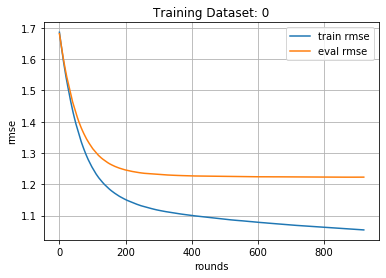

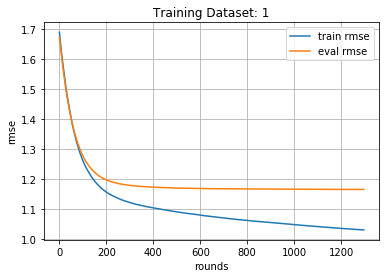

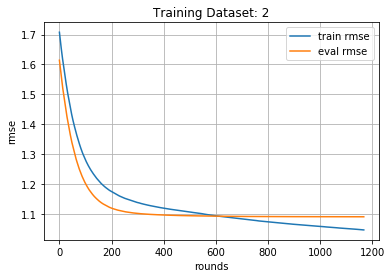

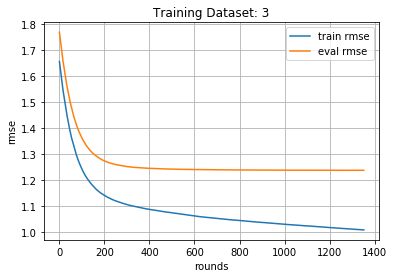

In [10]:
for i in range(4):
    plot_loss(histories[i],f'Training Dataset: {i}')

In [11]:
test_length = len(test_data)
predict = np.array([0.0]*test_length)
dtest = xgb.DMatrix(test_x,label=test_y) #本来は学習に使用していないデータにする
for i in range(4):
    y_pred_proba = models[i].predict(dtest)
    predict += y_pred_proba

predict /= 4

C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [12]:
y = pd.DataFrame(predict,columns=["y'"])
output = test_data #ここも書き換えること

output = pd.concat([output,y],axis=1)

output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/neweval.csv",index=False,encoding="shift-jis")

In [13]:
len(output)

40422